<a href="https://colab.research.google.com/github/chenant2017/MathModeling/blob/main/Forecast_by_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887

In [ ]:
!pip install pystan==2.19.1.1

In [ ]:
!pip install prophet

     |████████████████████████████████| 65 kB 1.9 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 214 kB 9.5 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640816 sha256=1ec8a7751fdbfc7107893f1b01c5080429ed8123321c1ddcbf52e1a5ccd02f44
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta

In [ ]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vT9FF5jsxkr2ljUN7Jk3cOkJ1fnp9bBB0yno45u_oF9eRYkNANJfYLqsqKxlMNYGMoxLu929uhC6han/pub?gid=426957286&single=true&output=csv")
df = df.iloc[:,:13]
df = pd.melt(df, id_vars="Year")
df.columns = ['year', 'month', 'elevation']


In [ ]:
df.query("elevation > 0")

,year,month,elevation
1,1936,JAN,907.90
2,1937,JAN,1022.20
3,1938,JAN,1095.00
4,1939,JAN,1165.40
5,1940,JAN,1166.90
...,...,...,...
1038,2016,DEC,1080.82
1039,2017,DEC,1082.52
1040,2018,DEC,1081.46
1041,2019,DEC,1090.49


In [ ]:
df.query("elevation > 0 and year >=1940").elevation.max()

1225.44

In [ ]:
np.percentile(df.query("elevation > 0 and year >=1940").elevation.values, 100)

1225.44

In [ ]:
pd.DataFrame({"range": range(0, 100), "value": np.percentile(df.query("elevation > 0 and year >=1940").elevation, range(0, 100))})

,range,value
0,0,1067.650
1,1,1075.218
2,2,1078.266
3,3,1079.712
4,4,1081.478
...,...,...
95,95,1211.160
96,96,1211.740
97,97,1212.770
98,98,1213.850


In [ ]:
def to_date(y, m):
  return dt.strptime("{} {}".format(y, m), "%Y %b")

ds = []
for _, row in df.iterrows():
  d = to_date(row["year"], row["month"])
  ds.append(d.strftime("%Y-%m-%d"))
df["ds"] = ds

In [ ]:
df.query("elevation > 0 and year > 1970")

,year,month,elevation,ds
36,1971,JAN,1152.87,1971-01-01
37,1972,JAN,1162.27,1972-01-01
38,1973,JAN,1172.75,1973-01-01
39,1974,JAN,1180.14,1974-01-01
40,1975,JAN,1178.74,1975-01-01
...,...,...,...,...
1038,2016,DEC,1080.82,2016-12-01
1039,2017,DEC,1082.52,2017-12-01
1040,2018,DEC,1081.46,2018-12-01
1041,2019,DEC,1090.49,2019-12-01


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=px.line(df.query("elevation > 0 and year > 1938").sort_values(by="ds"), x='ds', y="elevation"))

fig.add_shape(type='line',
              x0=0,
              y0=1075,
              x1=1,
              y1=1075,
              line=dict(color='Red',),
              xref='paper',
              yref='y'
)
fig.show()

### Cross-validation

In [ ]:
ddf = df.query("elevation > 0 and year >= 2005 and year <=2020")[["ds", "elevation"]].sort_values(by="ds")
ddf.columns = ['ds', 'y']

#xtrain = ddf.iloc[:-24]
#xtest = ddf.iloc[-24:]
xtrain = ddf

## If model is too high/low: bound it by cap/floor
xtrain['floor'] = 895
xtrain['cap'] = 1225

In [ ]:
import pandas as pd
# start training using 2005-2014's data. evaluate on 2015-2020's data
cutoffs = pd.date_range(start='2015-01-01', end='2018-12-01', freq='6MS')

In [ ]:
cutof fs

DatetimeIndex(['2015-01-01', '2015-07-01', '2016-01-01', '2016-07-01',
               '2017-01-01', '2017-07-01', '2018-01-01', '2018-07-01'],
              dtype='datetime64[ns]', freq='6MS')

In [ ]:
m = Prophet(
    weekly_seasonality=False,
    daily_seasonality=False)
m.fit(xtrain)

  0%|          | 0/8 [00:00<?, ?it/s]

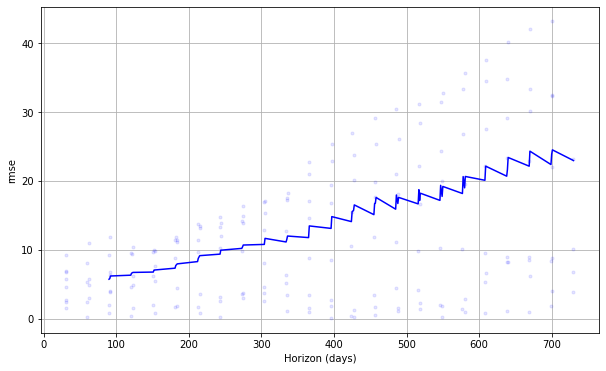

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

df_cv = cross_validation(model=m, horizon='730 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
m = Prophet(growth = 'logistic',
    weekly_seasonality=False,
    daily_seasonality=False)
m.fit(xtrain)

  0%|          | 0/8 [00:00<?, ?it/s]

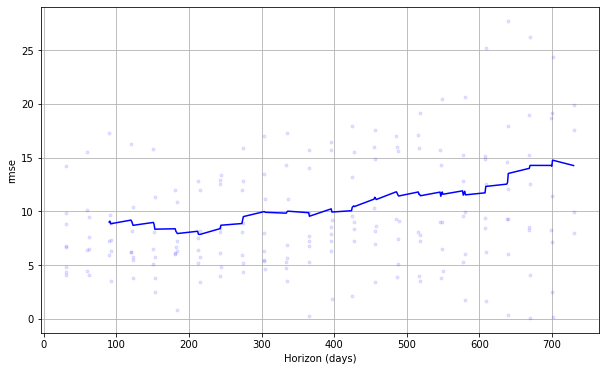

In [ ]:
df_cv = cross_validation(model=m, horizon='730 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
m = Prophet(growth = 'logistic',
    seasonality_mode = 'multiplicative',
    weekly_seasonality=False,
    daily_seasonality=False)
m.fit(xtrain)

  0%|          | 0/8 [00:00<?, ?it/s]

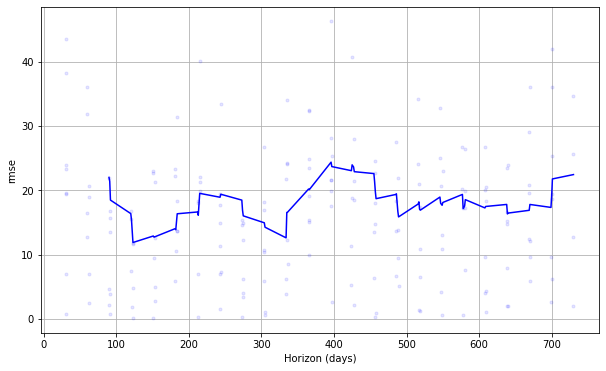

In [ ]:
df_cv = cross_validation(model=m, horizon='730 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [ ]:
## It seems the best model is logistic w/ floor and cap
m = Prophet(growth = 'logistic',
    weekly_seasonality=False,
    daily_seasonality=False)
m.fit(xtrain)

In [ ]:
future = m.make_future_dataframe(periods=12*30, freq='MS')
future['floor'] = 895
future['cap'] = 1225
ppred = m.predict(future)

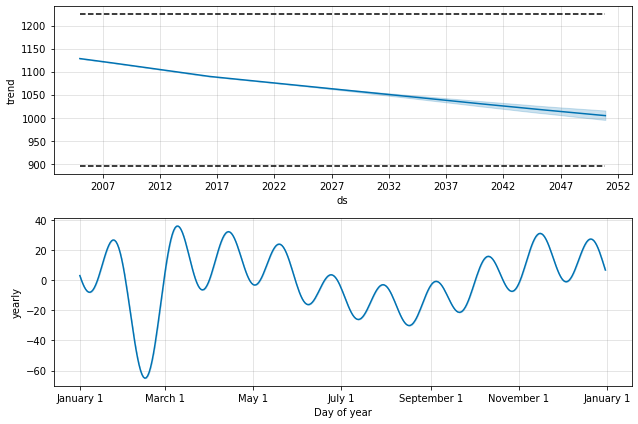

In [ ]:
fig = m.plot_components(ppred)
